# Rotation CIFAR Experiment

This experiment will use images from the **CIFAR-100** database (https://www.cs.toronto.edu/~kriz/cifar.html) and showcase the backward transfer efficiency of algorithms in the **ProgLearn** project (https://github.com/neurodata/ProgLearn) as the images are rotated.

In [1]:
# Import necessary packages
import numpy as np
import keras
from multiprocessing import Pool
from functools import partial

Using TensorFlow backend.


In [2]:
# Create array to store errors
errors_array = []

In [3]:
# Loads and reshapes data sets
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()

# Joins the training and testing arrays into one
data_x = np.concatenate([X_train, X_test]) 
data_y = np.concatenate([y_train, y_test]) 
data_y = data_y[:, 0]

## Hyperparameters

Hyperparameters determine how the model will run. 

`granularity` refers to the amount by which the angle will be increased each time. Setting this value at 1 will cause the algorithm to test every whole number rotation angle between 0 and 180 degrees.

`reps` refers to the number of repetitions tested for each angle of rotation. For each repetition, the data is randomly resampled.

`max_depth` refers to the maximum depth of each tree in the Lifelong Classification Forest. If this value is not specified, LifelongClassificationForest defaults to a max tree depth of 30.

In [4]:
### MAIN HYPERPARAMS ###
granularity = 2
reps = 10
max_depth = 30
########################

## Algorithms

The progressive-learning repo contains two main algorithms, **Lifelong Learning Forests** (L2F) and **Lifelong Learning Network** (L2N), within `forest.py` and `network.py`, respectively. The main difference is that L2F uses random forests while L2N uses deep neural networks. Both algorithms, unlike LwF, EWC, Online_EWC, and SI, have been shown to achieve both forward and backward knowledge transfer. 

For the purposes of this experiment, the L2F algorithm will be used.

## Experiment

If the chosen algorithm is trained on both straight up-and-down CIFAR images and rotated CIFAR images, rather than just straight up-and-down CIFAR images, will it perform better (achieve a higher backward transfer efficiency) when tested on straight up-and-down CIFAR images? How does the angle at which training images are rotated affect these results?

At a rotation angle of 0 degrees, the rotated images simply provide additional straight up-and-down CIFAR training data, so the backward transfer efficiency at this angle show whether or not the chosen algorithm can even achieve backward knowledge transfer. As the angle of rotation increases, the rotated images become less and less similar to the original dataset, so the backward transfer efficiency should logically decrease, while still being above 1.

In [5]:
# Odif
from functions.rotation_cifar_functions import odif_experiment

# Generate set of angles to test for BTE
angles = np.arange(0, 181, granularity)

# Parallel processing
with Pool(10) as p:
    # Multiple sets of errors for each set of angles are appended to a larger array containing errors for all angles
    # Calling LF_experiment will run the experiment at a new angle of rotation
    errors_array.append(
        p.map(partial(odif_experiment, data_x=data_x, data_y=data_y, granularity=granularity, max_depth=max_depth, reps=reps, ntrees=16, acorn=1), angles)
    )

Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/data/jayanta/ProgLearn/docs/experiments/functions/rotation_cifar_functions.py", line 107, in odif_experiment
    progressive_learner.add_task(X=train_x1, y=train_y1, n_estimators=ntrees)
  File "/home/jayanta/env/lib/python3.6/site-packages/proglearn-0.0.4-py3.6.egg/proglearn/forest.py", line 140, in add_task
    decider_kwargs={"classes": np.unique(y)},
  File "/home/jayanta/env/lib/python3.6/site-packages/proglearn-0.0.4-py3.6.egg/proglearn/progressive_learner.py", line 663, in add_task
    back

KeyboardInterrupt: 

## Rotation CIFAR Plot

This section takes the results of the experiment and plots the backward transfer efficiency against the angle of rotation for the images in **CIFAR-100**.

## Expected Results

If done correctly, the plot should show that Backward Transfer Efficiency (BTE) is greater than 1 regardless of rotation, but the BTE should decrease as the angle of rotation is increased. The more the number of reps and the finer the granularity, the smoother this downward sloping curve should look.

In [ ]:
# Calculate BTE for each angle of rotation
bte = []
for angle in angles:
    orig_error, transfer_error = errors_array[0][int(angle/granularity)] # (angle/granularity) gives the index of the errors for that angle
    bte.append(orig_error / transfer_error) # (original error/transfer error) gives the BTE

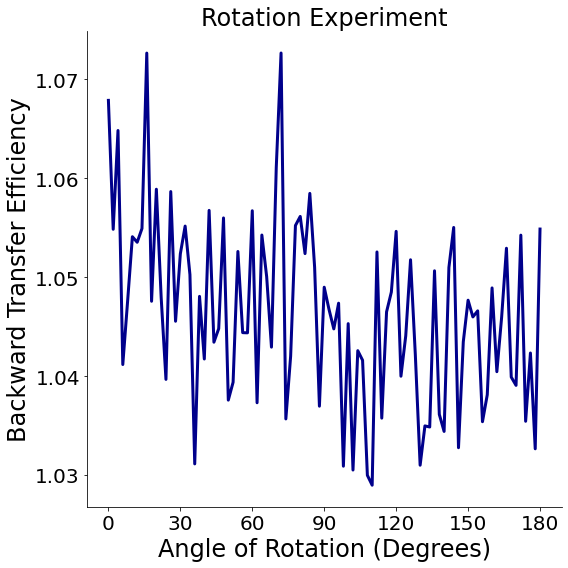

In [ ]:
# Plot angle of rotation vs. BTE
from functions.rotation_cifar_functions import plot_bte
plot_bte(bte, angles)

## FAQs

### Why am I getting an "out of memory" error?
`Pool(8)` in the previous cell allows for parallel processing, so the number within the parenthesis should be, at max, the number of cores in the device on which this notebook is being run. Even if a warning is produced, the results of the experimented should not be affected.

### Why is this taking so long to run? How can I speed it up to see if I am getting the expected outputs?
Decreasing the value of `reps`, decreasing the value of `max_depth`, or increasing the value of `granularity` will all decrease runtime at the cost of noisier results.